## snappables to partitions
specifically, snappable spanning trees to balanced 2-partitions. 

by definition, a snappable tree on a graph $G = (V, E)$ has exactly one edge that, if cut, breaks the tree into two subtrees of size $\frac{|V|}{2}$. those subtrees define a balanced 2-partition of $G$. every graph $G$ has some set $P$ of balanced 2-partitions, and my question is the following: what distribution over $P$ is induced by the uniform distribution over snappable trees? my guess is that it will be the spanning tree distribution, where each partition has density proportional to the product of the number of spanning trees in each part.

this might be easy to prove analytically, but i'm interested in investigating it experimentally here. to do so, i'll need the following tools (many of which already exist):
* a candidate graph $G$. this needs to be big enough to admit partitions with nontrivial spanning tree density, but small enough to limit the number of partitions to something reasonable. and also needs to have an even number of nodes. i think starting with the $4 \times 4$ square grid graph should be okay, but might want to scale down to the $3 \times 4$ rectangular grid.
* as we don't (yet) have an algorithm to uniformly sample snappable trees, we can either use wilson's algorithm to uniformly sample spanning trees, or my tree_utils function to enumerate all spanning trees of $G$. either way, we'll need a function to determine whether a tree is snappable (i think we can use jamie tucker-foltz's code here).
* it might be helpful to use some zdd code to double-check the number of balanced 2-partitions of square grid graphs
* we should probably add code to tree_utils to handle/identify partitions of graphs
* we should adapt the visualization tools from the gabe_wilsons.ipynb notebook to check the distribution over $P$ at the end

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tree_utils as tu
import matplotlib.pyplot as plt
from tree_partition import sample_uniform_partition_of_tree

In [81]:
def get_sp_scores(g, partition):
    prod = 1
    subgraphs = [g.subgraph(part) for part in partition]
    for subgraph in subgraphs:
        NST = tu.find_NST(subgraph)
        prod *= NST
    cut_edges = []
    for e in g.edges:
        if e not in subgraphs[0].edges and e not in subgraphs[1].edges:
            cut_edges.append(e)
    return (prod, prod * len(cut_edges))

In [82]:
get_sp_scores(g, partition)

(15, 75)

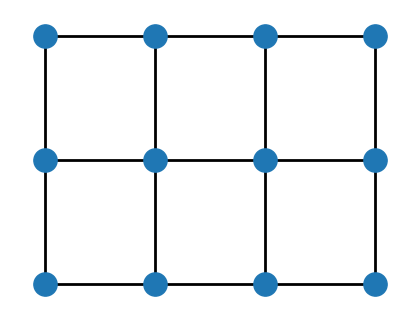

In [108]:
# N = 4
dims = (3,4)
g = tu.generate_grid_graph(dims, queen=False)
tu.draw(g)

In [109]:
all_trees = [tree for tree in tu.enumerate_all_trees(g)]

2415it [00:02, 1169.09it/s]


the file at `mggg/ZDD/outputs/julia_enumpart.txt` (on my computer) gives the following output at line 38

`rook 4x4 grid -> 2 districts (size 8+/-0): 70                       (Julia enumpart, took 0.119509776)`

so it seems there are 70 ways to partition the 4x4 grid into two equal connected parts of size 8. as a result of running the below code with a $3 \times 4$ grid graph, it looks like there are 18 ways to partition it into two equal connected parts of size 6.

In [110]:
# identify and set aside snappable trees
# part_size = (N ** 2) / 2
part_size = 6
all_snappables = []
for tree in tqdm(all_trees):
    for n in tree:
        tree.nodes[n]['pop'] = 1
    partition, num_balance_edges = sample_uniform_partition_of_tree(tree, 2, part_size, part_size, "pop")
    if num_balance_edges:
        sp_score, sp_ce_score = get_sp_scores(g, partition)
        for part in partition:
            if (0,0) in part:
                all_snappables.append((tree, set(part), sp_score, sp_ce_score))

100%|██████████████████████████████████████| 2415/2415 [00:04<00:00, 504.74it/s]


In [111]:
all_partitions = []
for tup in all_snappables:
    partition = tup[1]
    if partition not in all_partitions:
        all_partitions.append(partition)
# assert len(all_partitions) == 70 ## only for the 4x4 grid graph case.

# we need to label the partitions with integers in order to easily boxplot them
def indexer(partition):
    return all_partitions.index(partition)

partition_freqs = {indexer(partition): 0 for partition in all_partitions}
for tup in all_snappables:
    partition_freqs[indexer(tup[1])] += 1 /len(all_snappables)
    
# The below is to resort the partitions by frequency; it's unnecessarily confusing
resorted_list = sorted([(k, v) for (k, v) in partition_freqs.items()], key=lambda x:x[1], reverse=True)

def reindexer(partition):
    old_index = indexer(partition)
    resorted = [t[0] for t in resorted_list]
    return resorted.index(old_index)

partition_freqs = {reindexer(partition): 0 for partition in all_partitions}
for tup in all_snappables:
    partition_freqs[reindexer(tup[1])] += 1 /len(all_snappables)

partition_scores = {}
for tup in all_snappables:
    partition = tup[1]
    if reindexer(partition) not in partition_scores:
        partition_scores[reindexer(partition)] = tup[2] / 377 # NOTE -- this comes from summing over all partition scores, needs to be recomputed if g changes
        
partition_ce_scores = {}
for tup in all_snappables:
    partition = tup[1]
    if reindexer(partition) not in partition_ce_scores:
        partition_ce_scores[reindexer(partition)] = tup[3] / 1467 # NOTE -- this comes from summing over all partition scores, needs to be recomputed if g changes

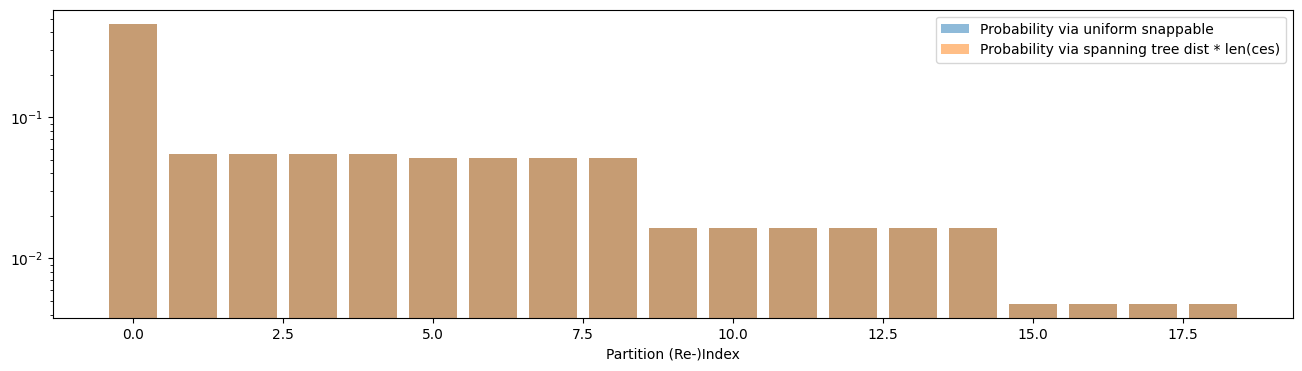

In [112]:
fig, ax = plt.subplots(figsize=(16,4))

plt.bar(x = partition_freqs.keys(),
        height = partition_freqs.values(),
        log=True,
        alpha=0.5,
        label="Probability via uniform snappable",
       )
# plt.bar(x = partition_scores.keys(),
#         height = partition_scores.values(),
#         log=True,
#         alpha=0.5,
#         label="Probability via spanning tree dist",
#        )
plt.bar(x = partition_ce_scores.keys(),
        height = partition_ce_scores.values(),
        log=True,
        alpha=0.5,
        label="Probability via spanning tree dist * len(ces)",
       )
plt.legend()
_ = plt.xlabel("Partition (Re-)Index")
# plt.savefig("distributions_3x4.png", dpi=600, bbox_inches='tight')

_the below is me trying to figure out why this wasn't lining up with the spanning tree dist, which was because it shouldn't! see above...._

## again, with actual uniform sampling
one reason the distributions might not be lining up is that that the number of snappable trees is coprime with the sum of the spanning tree scores over all partitions, which means the frequencies can never line up exactly. to ameliorate this, we could actually sample snappable trees uniformly by using wilson's and rejection sampling until we get a snappable tree. let's see if this works....

In [39]:
%%time
num_trials = 100000
all_snappables = []
for _ in tqdm(range(num_trials)):
    tree = tu.uniform_random_spanning_tree(g)
    for n in tree:
        tree.nodes[n]['pop'] = 1
    partition, num_balance_edges = sample_uniform_partition_of_tree(tree, 2, part_size, part_size, "pop")
    if num_balance_edges:
        sp_score = get_sp_score(g, partition)
        for part in partition:
            if (0,0) in part:
                all_snappables.append((tree, set(part), sp_score))

100%|██████████████████████████████████| 100000/100000 [04:49<00:00, 344.98it/s]

CPU times: user 4min 33s, sys: 15.5 s, total: 4min 48s
Wall time: 4min 49s


In [44]:
len(all_snappables)

60584

In [40]:
all_partitions = []
for tup in all_snappables:
    partition = tup[1]
    if partition not in all_partitions:
        all_partitions.append(partition)
# assert len(all_partitions) == 70 ## only for the 4x4 grid graph case.

# we need to label the partitions with integers in order to easily boxplot them
def indexer(partition):
    return all_partitions.index(partition)

partition_freqs = {indexer(partition): 0 for partition in all_partitions}
for tup in all_snappables:
    partition_freqs[indexer(tup[1])] += 1 /len(all_snappables)
    
# The below is to resort the partitions by frequency; it's unnecessarily confusing
resorted_list = sorted([(k, v) for (k, v) in partition_freqs.items()], key=lambda x:x[1], reverse=True)

def reindexer(partition):
    old_index = indexer(partition)
    resorted = [t[0] for t in resorted_list]
    return resorted.index(old_index)

partition_freqs = {reindexer(partition): 0 for partition in all_partitions}
for tup in all_snappables:
    partition_freqs[reindexer(tup[1])] += 1 /len(all_snappables)

    
partition_scores = {}
for tup in all_snappables:
    partition = tup[1]
    if reindexer(partition) not in partition_scores:
        partition_scores[reindexer(partition)] = tup[2] / 377 # NOTE -- this comes from summing over all partition scores, needs to be recomputed if g changes

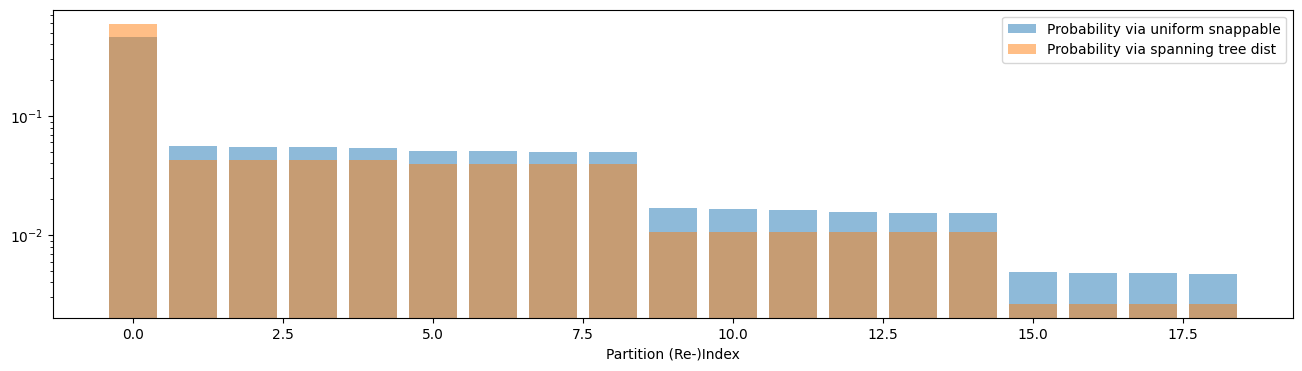

In [41]:
fig, ax = plt.subplots(figsize=(16,4))

plt.bar(x = partition_freqs.keys(),
        height = partition_freqs.values(),
        log=True,
        alpha=0.5,
        label="Probability via uniform snappable",
       )
plt.bar(x = partition_scores.keys(),
        height = partition_scores.values(),
        log=True,
        alpha=0.5,
        label="Probability via spanning tree dist",
       )
plt.legend()
_ = plt.xlabel("Partition (Re-)Index")
# plt.savefig("distributions_3x4.png", dpi=600, bbox_inches='tight')

hmmm okay that didn't work -- it really seems like they just are different distributions?? the one other thing I can check is whether the distributions get closer or farther apart as the graph size increases:

In [49]:
df = pd.read_csv("2x4_distributions.csv", index_col=0)

In [80]:
def statistical_difference(df):
    dist = 0
    for i in df.index:
        dist += abs(df.freq.iloc[i] - df.score.iloc[i])
    return 0.5 * dist

def max_difference(df):
    max_diff = 0
    for i in df.index:
        max_diff = max(max_diff, abs(df.freq.iloc[i] - df.score.iloc[i]))
    return max_diff

In [81]:
for n in [2,3,4,5]:
    df = pd.read_csv(f"{n}x4_distributions.csv", index_col=0)
    stat_diff = statistical_difference(df)
    max_diff = max_difference(df)
    print(f"{n}x4: \n  {stat_diff}\n  {max_diff}")

2x4: 
  0.1148325358851676
  0.11483253588516773
3x4: 
  0.13669427674081516
  0.1366942767408122
4x4: 
  0.11890665198678496
  0.059453325993367
5x4: 
  0.08509555579476107
  0.026793772133356403


this is weird -- the statistical distance doesn't strictly decrease with the size of the graph. this is really making me feel like these are just different distributions!